# Estimated Time of Arrival prediction (ETA) using the Chicago Taxi Trips dataset


## Overview

This notebook was builded as the Demo 4 for the Generative AI - Services Specialization Partner as an example of and end-to-end Vertex API Pipeline, using the Chicago taxi trips dataset (Bigquery) to improve its service. In this particular case it will be used it for improve the trip predicted time at the start of the service (ETA). This demo use Vertex AI, CloudStorage and BigQuery.

### Objective

The goal of this demo is to provide an overview on Vertex AI features like Explainable AI and BigQuery in Notebooks by trying to solve a taxi trip prediction problem.
The steps performed include:

- Loading the dataset using "BigQuery in Colab".
- Performing exploratory data analysis on the dataset.
- Feature selection and preprocessing.
- Building a linear regression model using scikit-learn.
- Configuring the model for Vertex Explainable AI.
- Deploying the model to Vertex AI.
- Testing the deployed model.

## Dataset Overview

This project utilizes the Chicago Taxi Trips dataset (bigquery-public-data.chicago_taxi_trips.taxi_trips), a public dataset hosted on Google BigQuery. It contains historical data on taxi trips reported to the City of Chicago from 2013 to the present

## Key Features & Schema

We will focus on a subset of available fields for this demonstration:

*   trip_seconds (Target): The total duration of the trip in seconds. This is the variable we want to predict
*   trip_miles: The distance of the trip in miles
*   trip_start_timestamp: The date and time the trip started. We will extract the Hour and Day of the week from this field to capture traffic patterns
*   pickup_community_area: An integer ID representing the community area where the trip began
*   dropoff_community_area: An integer ID representing the community area where the trip ended.



## Install Vertex AI SDK, BQ and other packages

In [1]:
!pip install --upgrade google-cloud-aiplatform google-cloud-bigquery kfp scikit-learn==1.3.2

## Import Libraries, create CloudStorage Bucket and BigQuery Integration

In [ ]:
import sys
import os
from google.cloud import aiplatform, bigquery_connection, bigquery

#Config
PROJECT_ID = "YOUR_PROJECT_ID"
REGION = "YOUR_LOCATION"
BUCKET_NAME = "YOUR_BUCKET_NAME"
#Vertex AI SKD
aiplatform.init(project="YOUR_PROJECT_ID", location="YOUR_LOCATION", staging_bucket="YOUR_BUCKET_NAME")
#BigQuery Initialization
bq_client = bigquery.Client(project="YOUR_PROJECT_ID")
#Bucket URI - pipeline
BUCKET_URI = f"gs://YOUR_BUCKET_NAME"

print(f"settings for Vertex AI SDK for project: {PROJECT_ID} in Region: {REGION}")
print (f"Artifacts Bucket: {BUCKET_URI}")

settings for Vertex AI SDK for project: genai-partner-demo4 in Region: us-central1
Artifacts Bucket: gs://genai-partner-demo4-vertex-artifacts


In [ ]:
#Data Exploration
TABLE_NAME = "bigquery-public-data.chicago_taxi_trips.taxi_trips"

query = f"""
select * from `{TABLE_NAME}`
limit 10
"""

df_exploration = bq_client.query(query).to_dataframe()
df_exploration.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,f1f4c25386cd6a0b7553c1fbf0876d865ed40af5,844d31fb7f6f3309d359dd6ed2929246bbffb8937c5bec...,2016-06-01 21:00:00+00:00,2016-06-01 21:15:00+00:00,471,2.3,<NA>,<NA>,<NA>,<NA>,...,0.0,7.4,Cash,303 Taxi,NaN,NaN,None,NaN,NaN,None
1,51dfff35315102c2480a26c9a7ce852a85195ad6,844d31fb7f6f3309d359dd6ed2929246bbffb8937c5bec...,2016-06-01 21:15:00+00:00,2016-06-01 21:30:00+00:00,463,2.1,<NA>,<NA>,<NA>,<NA>,...,2.0,9.2,Cash,303 Taxi,NaN,NaN,None,NaN,NaN,None
2,fc4449736c9c7f5270e2047a0a61624f101c5de6,844d31fb7f6f3309d359dd6ed2929246bbffb8937c5bec...,2016-06-02 17:00:00+00:00,2016-06-02 17:15:00+00:00,714,2.2,<NA>,<NA>,<NA>,<NA>,...,0.0,9.0,Cash,303 Taxi,NaN,NaN,None,NaN,NaN,None
3,f065cef080f0709d48f55b73d933cfe946f55bb6,844d31fb7f6f3309d359dd6ed2929246bbffb8937c5bec...,2016-06-02 17:30:00+00:00,2016-06-02 17:45:00+00:00,635,2.3,<NA>,<NA>,<NA>,<NA>,...,0.0,9.0,Cash,303 Taxi,NaN,NaN,None,NaN,NaN,None
4,6f2067b9af93cd0e3dffc72b1e3f690747cea260,844d31fb7f6f3309d359dd6ed2929246bbffb8937c5bec...,2016-06-02 18:00:00+00:00,2016-06-02 18:15:00+00:00,603,3.7,<NA>,<NA>,<NA>,<NA>,...,1.0,11.2,Cash,303 Taxi,NaN,NaN,None,NaN,NaN,None


## Feature Exploration / Selection

We will gonna choose just the fields related to ETA

In [ ]:
#Feature Explorarion / Selection
TABLE_NAME = "bigquery-public-data.chicago_taxi_trips.taxi_trips"

query = f"""
select
  trip_seconds,
  trip_miles,
  pickup_community_area,
  dropoff_community_area,
  trip_start_timestamp
from `{TABLE_NAME}`
limit 10
"""

df = bq_client.query(query).to_dataframe()
df.head()

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,trip_start_timestamp
0,1080,3.6,<NA>,<NA>,2017-03-16 08:45:00+00:00
1,480,0.9,<NA>,<NA>,2017-03-16 09:15:00+00:00
2,420,0.8,<NA>,<NA>,2017-03-16 09:30:00+00:00
3,480,1.1,<NA>,<NA>,2017-03-16 10:30:00+00:00
4,240,0.5,<NA>,<NA>,2017-03-16 11:15:00+00:00


### Date Range selection

For the porpuse of the Demo and the amount of data we will use 2 weeks: from 2023-11-01 to 2023-11-14

In [ ]:
query = f"""
select
  min(trip_start_timestamp) as trip_start_timestamp_min,
  max(trip_start_timestamp) as trip_start_timestamp_max
from `{TABLE_NAME}`
"""

min_max_dates = bq_client.query(query).to_dataframe()
min_max_dates.head()

,trip_start_timestamp_min,trip_start_timestamp_max
0,2013-01-01 00:00:00+00:00,2023-12-31 23:45:00+00:00


In [ ]:
cost_query = f"""
select
  trip_seconds,
  trip_miles,
  pickup_community_area,
  dropoff_community_area,
  trip_start_timestamp
from `{TABLE_NAME}`
where trip_start_timestamp between '2023-11-01' and '2023-11-14'
and trip_seconds > 60
and trip_miles > 0
and pickup_community_area is not null
and dropoff_community_area is not null
order by trip_start_timestamp
"""

job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
query_job = bq_client.query(cost_query, job_config=job_config)

bytes_processed = query_job.total_bytes_processed
gb_processed = bytes_processed / (1024 ** 3)
cost_per_tb = 6.25
estimated_cost = (bytes_processed / 1024**4) * cost_per_tb

print(f"Esta consulta procesara {gb_processed:.4f} GB")
print(f"Costo Estimado: ${estimated_cost} USD")

Esta consulta procesara 7.4818 GB
Costo Estimado: $0.0456651833246724 USD


### Feature selection and sample data

In [ ]:
#Feature Explorarion / Selection
TABLE_NAME = "bigquery-public-data.chicago_taxi_trips.taxi_trips"

query = f"""
select
  trip_seconds,
  trip_miles,
  pickup_community_area,
  dropoff_community_area,
  trip_start_timestamp
from `{TABLE_NAME}`
where trip_start_timestamp between '2023-11-01' and '2023-11-14'
and trip_seconds > 60
and trip_miles > 0
and pickup_community_area is not null
and dropoff_community_area is not null
order by trip_start_timestamp
"""

df = bq_client.query(query).to_dataframe()
df.head()

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,trip_start_timestamp
0,1140,11.80,7,69,2023-11-01 00:00:00+00:00
1,1635,21.15,76,35,2023-11-01 00:00:00+00:00
2,420,1.50,32,33,2023-11-01 00:00:00+00:00
3,1440,12.10,56,28,2023-11-01 00:00:00+00:00
4,1279,17.67,76,32,2023-11-01 00:00:00+00:00


### Check shape of dataframe

In [ ]:
df.shape

(192559, 5)

### Describe the numerical fields

In [ ]:
df[["trip_seconds", "trip_miles"]].describe().T

,count,mean,std,min,25%,50%,75%,max
trip_seconds,192559.0,1372.60582,1613.274014,61.0,540.0,1020.0,1920.0,84226.0
trip_miles,192559.0,7.168276,7.367941,0.01,1.28,3.76,12.73,810.5


### Looking for Null values in the Dataframe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192559 entries, 0 to 192558
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   trip_seconds            192559 non-null  Int64              
 1   trip_miles              192559 non-null  float64            
 2   pickup_community_area   192559 non-null  Int64              
 3   dropoff_community_area  192559 non-null  Int64              
 4   trip_start_timestamp    192559 non-null  datetime64[us, UTC]
dtypes: Int64(3), datetime64[us, UTC](1), float64(1)
memory usage: 7.9 MB


Because of the variable values and definition is easy in this case for identify which fields would be categorical or numerical. Also because the definition of the problem is the estimated time of arrival we will create a Target Variable who will be trip_seconds.

In [ ]:
cat_col = ["pickup_community_area", "dropoff_community_area"]
num_cols = "trip_miles"
target = "trip_seconds"

 Also we need extract some features that affect the traffic like hour of the day and day of the week. We can get this data from trip_start_timestamp. The following script summarize the Feature Engineering of this part

In [ ]:
Dataset_ID = "taxi_ml_dataset"
Table_ID = "training data"
START_DATE = '2023-11-01'
END_DATE = '2023-11-14'

feature_engineering_query = f"""
SELECT
  trip_seconds,
  trip_miles,
  pickup_community_area,
  dropoff_community_area,
  EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day,
  EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS day_of_week
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  trip_start_timestamp BETWEEN TIMESTAMP('{START_DATE}') AND TIMESTAMP('{END_DATE}')
  AND trip_seconds > 60 AND trip_seconds < 7200
  AND trip_miles > 0
  AND pickup_community_area IS NOT NULL
  AND dropoff_community_area IS NOT NULL
"""

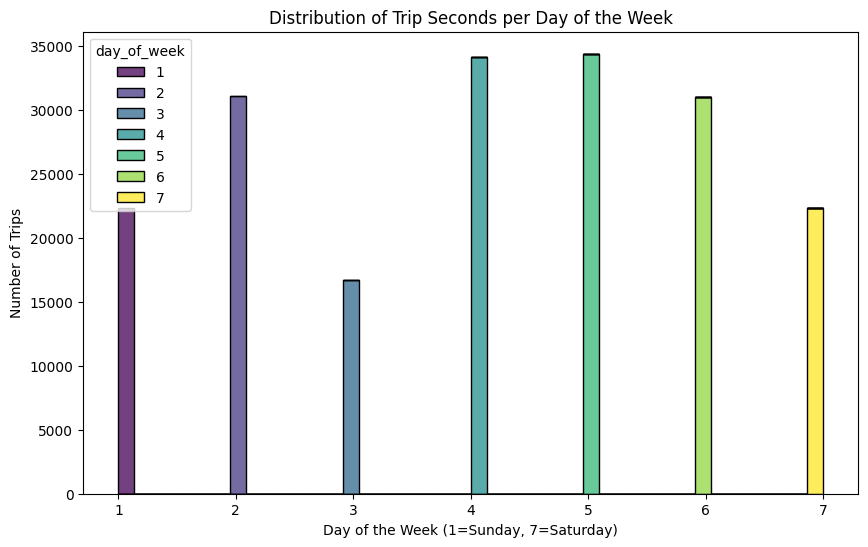

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_feature_engineering = bq_client.query(feature_engineering_query).to_dataframe()

plt.figure(figsize=(10, 6))
sns.histplot(data=df_feature_engineering, x='day_of_week', hue='day_of_week', multiple='stack', palette='viridis')
plt.title('Distribution of Trip Seconds per Day of the Week')
plt.xlabel('Day of the Week (1=Sunday, 7=Saturday)')
plt.ylabel('Number of Trips')
plt.show()

Seems like there are more trips in some days than another

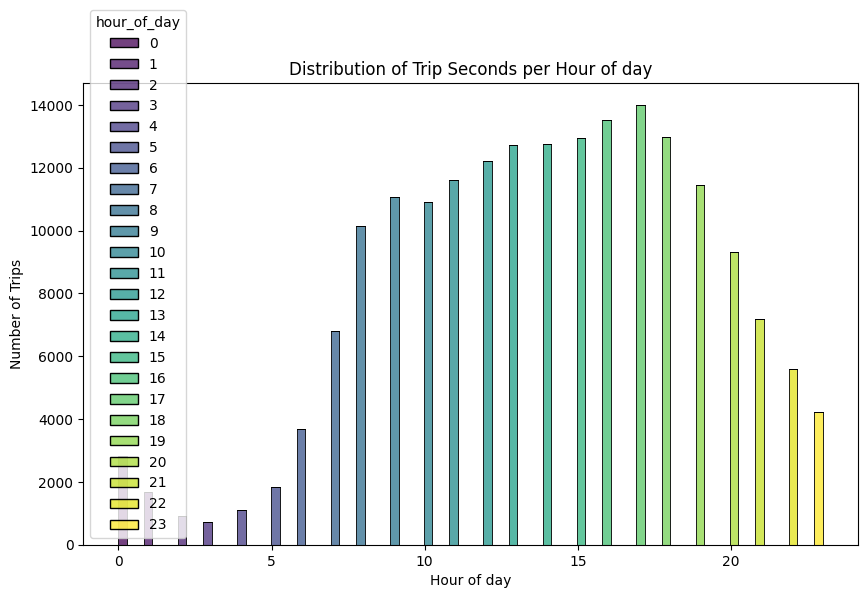

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_feature_engineering = bq_client.query(feature_engineering_query).to_dataframe()

plt.figure(figsize=(10, 6))
sns.histplot(data=df_feature_engineering, x='hour_of_day', hue='hour_of_day', multiple='stack', palette='viridis')
plt.title('Distribution of Trip Seconds per Hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Number of Trips')
plt.show()

The same applies for the hour of the day, where most trips are made between 11:00AM and 6:*00PM*

/tmp/ipython-input-691340866.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_feature_engineering, x='day_of_week', y='trip_seconds', palette='viridis')


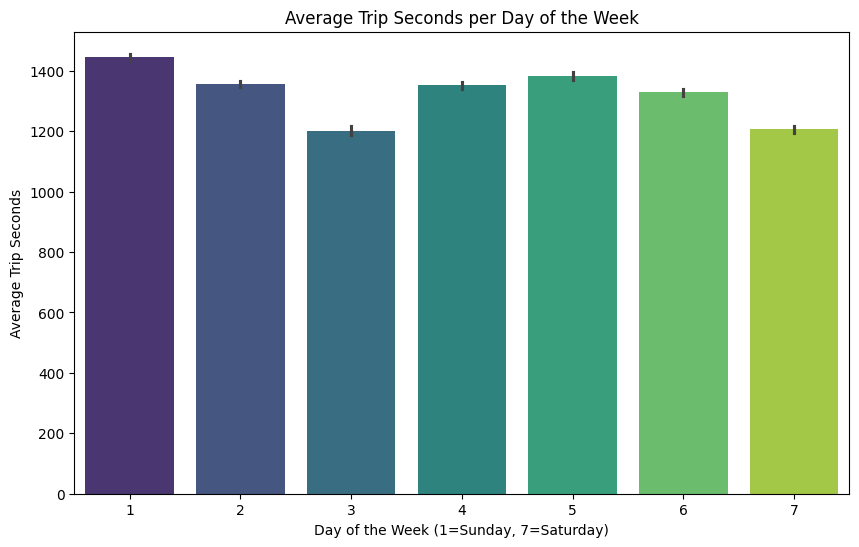

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_feature_engineering = bq_client.query(feature_engineering_query).to_dataframe()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_feature_engineering, x='day_of_week', y='trip_seconds', palette='viridis')
plt.title('Average Trip Seconds per Day of the Week')
plt.xlabel('Day of the Week (1=Sunday, 7=Saturday)')
plt.ylabel('Average Trip Seconds')
plt.show()


Sunday seems to be the day where the trips takes more time and tuesday where the trips takes less

### Heatmap Origin - Arrival

This heatmap could help us to understand "from where to where travels the people?".
Because there are too many zones in Chicago we will use just the top 15 zones.

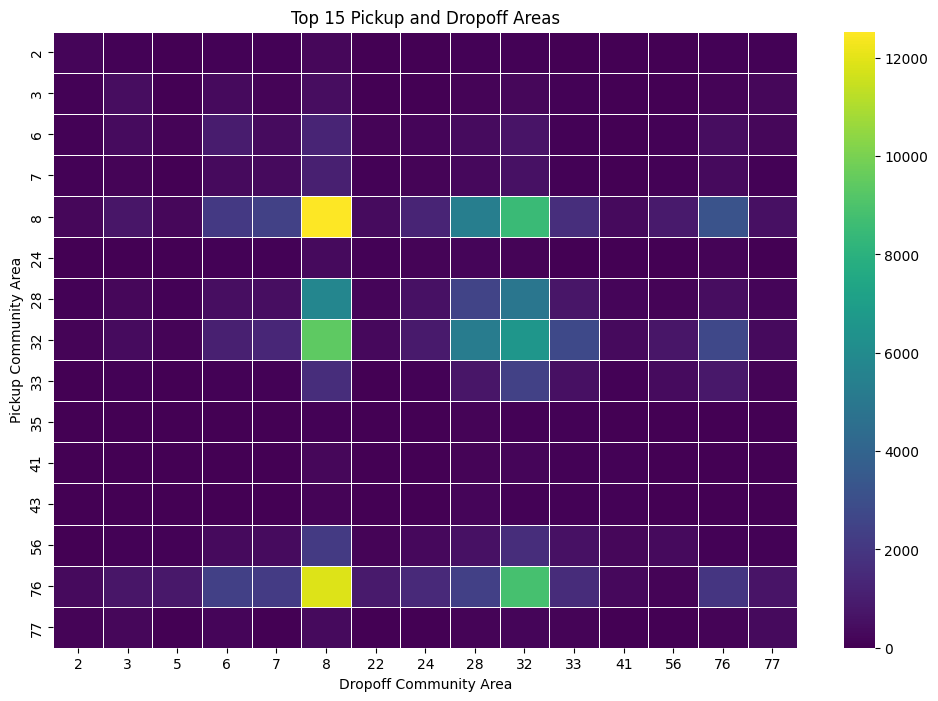

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_eda = df_feature_engineering

#forcing convert to number
df_eda['pickup_community_area'] = pd.to_numeric(df_eda['pickup_community_area'], errors='coerce')
df_eda['dropoff_community_area'] = pd.to_numeric(df_eda['dropoff_community_area'], errors='coerce')
df_eda['trip_seconds'] = pd.to_numeric(df_eda['trip_seconds'], errors='coerce')

#df clean NaN
df_eda = df_eda.dropna(subset=['pickup_community_area', 'dropoff_community_area', 'trip_seconds'])

# Get the top 15 most common traffic
top_pickup = df_eda['pickup_community_area'].value_counts().nlargest(15).index
top_dropoff = df_eda['dropoff_community_area'].value_counts().nlargest(15).index

# Filter the dataframe to include only the top 15 pickup and dropoff areas
df_top_traffic = df_eda[df_eda['pickup_community_area'].isin(top_pickup) & df_eda['dropoff_community_area'].isin(top_dropoff)]

# Create a pivot table to count the number of trips for each combination of pickup and dropoff areas
pivot_table = df_top_traffic.pivot_table(index='pickup_community_area', columns='dropoff_community_area', values='trip_seconds', aggfunc='count').fillna(0)
pivot_table = pivot_table.astype(float)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=False, linewidths=0.5)
plt.title('Top 15 Pickup and Dropoff Areas')
plt.xlabel('Dropoff Community Area')
plt.ylabel('Pickup Community Area')
plt.show()

According to [Community Areas in Chicago](https://en.wikipedia.org/wiki/Community_areas_in_Chicago) Seems like the most commun routes are in the dataframe are:
Zone 8 (Near North Side) to Zone 8 (Near North Side)

*   Zone 8 (Near North Side) to Zone 8 (Near North Side)
*   Zone 8 (Near North Side) to Zone 28 (Near West Side)
*   Zone 8 (Near North Side) to Zone 32 (Loop)
*   Zone 32 (Loop) to Zone 32 (Loop)
*   Zone 32 (Near North Side) to Zone 28 (Near West Side)
*   Zone 76 (O'Hare) to Zone 8 (Near North Side)
*   Zone 76 (O'Hare) to Zone 32 (Loop)


### Distance time relation

We should expect that the longer trips takes more time to complete

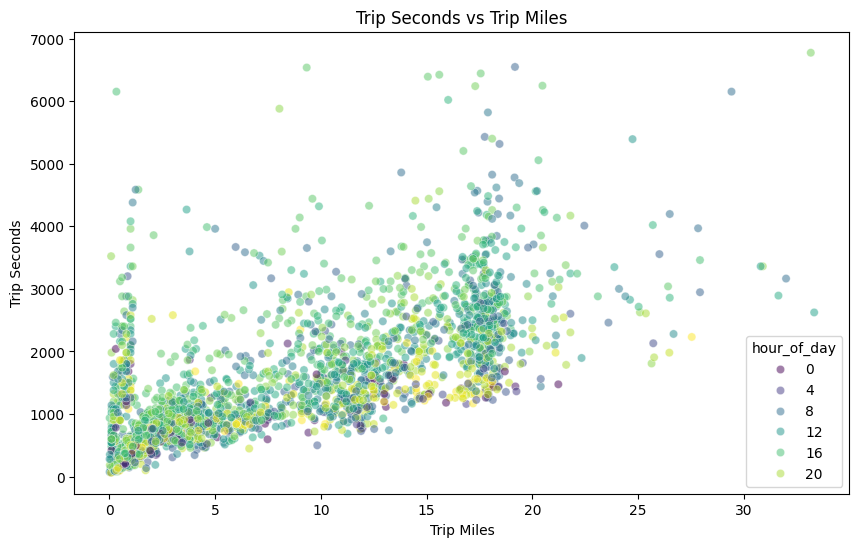

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_feature_engineering.sample(3000),
    x='trip_miles',
    y='trip_seconds',
    alpha = 0.5,
    palette='viridis',
    hue=df_feature_engineering['hour_of_day'].astype(int) # Convert hour_of_day to standard int type
)
plt.title('Trip Seconds vs Trip Miles')
plt.xlabel('Trip Miles')
plt.ylabel('Trip Seconds')
plt.show()

There are a clear lineal correlation between distance and time, but also there is some noise that the model should considerate

### Boxplot: Trip duration per Hour of the day

We should expect that there is some hours of the day where the trips take longer than another ones, even if we build an histogram steps before, boxplots will help us to clearify with better knowledge this hypothesis

/tmp/ipython-input-2048327817.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_feature_engineering, x='hour_of_day', y='trip_seconds', palette='viridis')


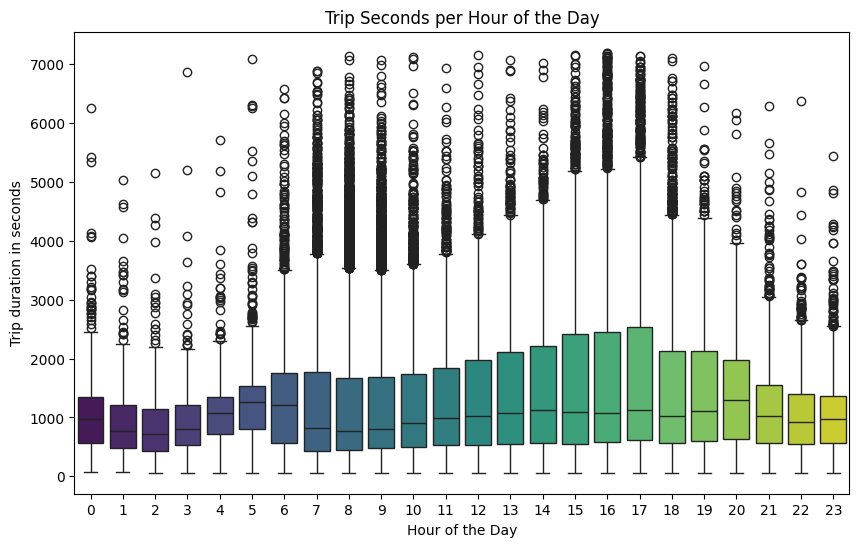

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_feature_engineering, x='hour_of_day', y='trip_seconds', palette='viridis')
plt.title('Trip Seconds per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Trip duration in seconds')
plt.show()

At 17:00hrs the median and the size of the box increase, that means there is more uncertaintly over the trip duration.
Also at 5:00am, 6:00am and 20:00hrs the trips tend to have a median higher than the rest

## Store dataset in BigQuery (Artifact #2: "Data in Google Cloud")



In [ ]:
Dataset_ID = "taxi_ml_dataset"
table_ID = "training_data"

dataset_ref = bigquery.Dataset(f"{PROJECT_ID}.{Dataset_ID}")
dataset_ref.location = 'US'

try:
  bq_client.create_dataset(dataset_ref, exists_ok=True)
  print(f"Dataset {Dataset_ID} created successfully")
except Exception as e:
  print(f"Error creating dataset: {e}")

materialize_query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{Dataset_ID}.{Table_ID}` AS
{feature_engineering_query}
"""

print(f"creating table")
job = bq_client.query(materialize_query)
job.result()

print(f"Success! Materialized Table")

Dataset taxi_ml_dataset created successfully
creating table
Success! Materialized Table


# Training Model

In this section we will train a model for predict estimated time of arrival

## Train and Test Split


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import pandas as pd
Dataset_ID = "taxi_ml_dataset"
Table_ID = "training data"

#Data in memory if needed
query = f"select * from `{PROJECT_ID}.{Dataset_ID}.{Table_ID}`"
df = bq_client.query(query).to_dataframe()

#Columns and target definitions
cols = ['trip_miles', 'pickup_community_area', 'dropoff_community_area', 'hour_of_day','day_of_week']
target = 'trip_seconds'

#X and Y prepararion
X = df[cols].copy()
y = df[target].copy()
X = X.fillna(0)

#Data train, test split (75% train, 25%test)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=14)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (144150, 5)
X_test shape: (48051, 5)


## Training the model

In [9]:
print("Training model, Random Forest...")
model = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=14)
model.fit(X_train, y_train)

Training model, Random Forest...


RandomForestRegressor(max_depth=10, n_estimators=20, random_state=14)

## Evaluating the Model

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
#metrics
mse = mean_squared_error(y_test, y_pred) # Calculate Mean Squared Error
rmse = np.sqrt(mse) # Calculate Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f} seconds")
print(f"R2 Score: {r2:.4f}")

RMSE: 484.03 seconds
R2 Score: 0.7765


## Conclusions about the model

R2 of 0.77 means that the model explain almost 80% of the trafic variability wich is a high number considerating the noise in the real data. Also an RMSE of 8minutes (484s) in a complex city like Chicago seems like a good first approach.
The current model could improve their results with more data like real-time GPS data, weather data, or even traffic events data like accindents. With that we could improve the results.

## Saving the model

In [11]:
joblib.dump(model, 'model.joblib')
print("Model saved")

Model saved


# Upload and Model Deployment

## Model upload to GCS

In [12]:
from google.cloud import aiplatform
from google.cloud import storage
import time

#Configuration
TIMESTAMP = time.strftime("%Y%m%d_%H%M%S")
MODEL_DISPLAY_NAME = f"taxi-trip-predictor-{TIMESTAMP}"
ENDPOINT_DISPLAY_NAME = f"taxi-endpoint-{TIMESTAMP}"
#Container
SERVING_IMAGE_URI = "us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-3:latest"

#Model upload to Google Clous Storage

artifact_uri =f"{BUCKET_URI}/model_artifacts/{TIMESTAMP}"
model_local_file = "model.joblib"

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)
blob = bucket.blob(f"model_artifacts/{TIMESTAMP}/model.joblib")
blob.upload_from_filename(model_local_file)
print("Saved model to GCS")

Saved model to GCS


## Model Registry in Vertex AI

In [13]:
model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=artifact_uri,
    serving_container_image_uri=SERVING_IMAGE_URI,
    serving_container_predict_route="/predict",
    serving_container_health_route="/health"
)

print(f"model registered with ID:{model.name}")

model registered with ID:1295566645636366336


## Deployment - Endpoint

In [14]:
endpoint= model.deploy(deployed_model_display_name=f"deployed-{MODEL_DISPLAY_NAME}",
                       machine_type="n1-standard-2",
                       min_replica_count=1,
                       max_replica_count=1,
                       sync=True)
print(f"endpoint deployed with ID:{endpoint.resource_name} ACTIVE")


endpoint deployed with ID:projects/3652667089/locations/us-central1/endpoints/3942434181321064448 ACTIVE


#Endopint Validation

Trip simulation: 5 miles trip from Zone 32 (The Loop) to Zone 76 (O'hare Airport) Tusday 5 PM

In [16]:
# test_trip = [5 miles, Zone 32, Zone 76, 17 hours, Tuesday (3) ]
test_trip = [5.0, 32, 76, 17, 3]

prediction = endpoint.predict([test_trip])
if prediction.predictions:
  seconds = prediction.predictions[0]
  minutes = seconds / 60
  print(f"Predicted trip time: {seconds:.2f} seconds")
  print(f"Predicted trip time: {minutes:.1f} minutes")
else:
  print("No predictions returned")

Predicted trip time: 1406.49 seconds
Predicted trip time: 23.4 minutes


#Recover Data and Config

If needed, run the following section for setting the project just before training the model and run again "Training the model section" for load variables in memory

In [ ]:
### Recover Data and Config ###

import os
import pandas as pd
import numpy as np
import joblib
from google.cloud import bigquery
from google.cloud import storage
from google.cloud import aiplatform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#Config
PROJECT_ID = "YOUR_PROJECT_ID"
REGION = "YOUR_LOCATION"
BUCKET_NAME = "YOUR_BUCKET_NAME"
#Vertex AI SKD
aiplatform.init(project="YOUR_PROJECT_ID", location="YOUR_LOCATION", staging_bucket="YOUR_BUCKET_NAME")
#BigQuery Initialization
bq_client = bigquery.Client(project="YOUR_PROJECT_ID")
#Bucket URI - pipeline
BUCKET_URI = f"gs://YOUR_BUCKET_NAME"

Dataset_ID = "taxi_ml_dataset"
Table_ID = "training data"

#Reload data from BigQuery
query = f"""
SELECT * FROM `{PROJECT_ID}.{Dataset_ID}.{Table_ID}`
"""

try:
  df = bq_client.query(query).to_dataframe

except Exception as e:
  print(e)

#Define columnes and prep X/y for test and split
  cols = ['trip_miles', 'pickup_community_area', 'dropoff_community_area', 'hour_of_day', 'day_of_week']
  target = 'trip_seconds'
  df = df.fillna(0)

  X = df[cols].copy()
  y = df[target].copy()

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=14)
  print(f"All set, the vatiables X_train, y_train are in memory")
  print(f"X_train shape: {X_train.shape}")
  print(f"X_test shape: {X_test.shape}")


